In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from datetime import datetime,timedelta
import datetime as dt
from sklearn.metrics import classification_report


In [ ]:
# DATA Collection

urls = ['https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2015_wta.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2016_wta.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2017_wta.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2018_wta.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2019_wta.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2020_wta.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2021_wta.csv']

dfs = [pd.read_csv(url,sep=';') for url in urls]
data = pd.concat(dfs, ignore_index=True)

# Keep colums we need

data.drop(['WPts','LPts','W1','L1','W2','L2','W3','L3','Wsets','Lsets','EXW','EXL','LBW','LBL','MaxW','MaxL','AvgW','AvgL'],axis=1,inplace=True)

#Format adjustment

data.PSW= (data.PSW.replace(',','.', regex=True).astype(float))
data.PSL= (data.PSL.replace(',','.', regex=True).astype(float))
data.B365W= (data.B365W.replace(',','.', regex=True).astype(float))
data.B365L= (data.B365L.replace(',','.', regex=True).astype(float)) 

data['Date'] = pd.to_datetime(data.Date,dayfirst=True)

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


In [ ]:
data.head(15)

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL
0,1,Auckland,ASB Classic,2015-01-04,International,Outdoor,Hard,1st Round,3,Davis L.,Rogers S.,54.0,72.0,Completed,1.66,2.10,1.77,2.16
1,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Kanepi K.,Petkovic A.,52.0,13.0,Completed,2.50,1.50,2.43,1.62
2,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Suarez Navarro C.,Pironkova T.,17.0,37.0,Completed,1.22,4.00,1.28,4.02
3,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Lepchenko V.,Stosur S.,34.0,21.0,Completed,3.00,1.36,3.09,1.42
4,3,Shenzhen,Shenzhen Open,2015-01-04,International,Outdoor,Hard,1st Round,3,Vikhlyantseva N.,Friedsam A.L.,584.0,93.0,Completed,3.25,1.33,3.18,1.40
5,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Svitolina E.,Rybarikova M.,28.0,48.0,Completed,1.40,2.75,1.43,3.01
6,3,Shenzhen,Shenzhen Open,2015-01-04,International,Outdoor,Hard,1st Round,3,Bacsinszky T.,Voegele S.,47.0,89.0,Completed,1.33,3.25,1.32,3.66
7,3,Shenzhen,Shenzhen Open,2015-01-04,International,Outdoor,Hard,1st Round,3,Babos T.,Wang Q.,96.0,101.0,Completed,2.10,1.66,2.03,1.86
8,3,Shenzhen,Shenzhen Open,2015-01-04,International,Outdoor,Hard,1st Round,3,Diyas Z.,Vekic D.,32.0,81.0,Completed,1.44,2.62,1.52,2.70
9,3,Shenzhen,Shenzhen Open,2015-01-04,International,Outdoor,Hard,1st Round,3,Schmiedlova A.,Koukalova K.,73.0,39.0,Completed,2.00,1.72,2.07,1.83


# **CODE PROPRE**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14921 entries, 0 to 14920
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   WTA         14921 non-null  int64         
 1   Location    14921 non-null  object        
 2   Tournament  14921 non-null  object        
 3   Date        14921 non-null  datetime64[ns]
 4   Tier        14921 non-null  object        
 5   Court       14921 non-null  object        
 6   Surface     14921 non-null  object        
 7   Round       14921 non-null  object        
 8   Best of     14921 non-null  int64         
 9   Winner      14921 non-null  object        
 10  Loser       14921 non-null  object        
 11  WRank       14904 non-null  float64       
 12  LRank       14878 non-null  float64       
 13  Comment     14921 non-null  object        
 14  B365W       14853 non-null  float64       
 15  B365L       14854 non-null  float64       
 16  PSW         14848 non-

## **Data Pre-processing**

#### ELO ranking calculation

In [ ]:

def compute_elo_rankings(data):
    """
    Given the list of matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index) # Gather all players from data
    elo=pd.Series(np.ones(len(players))*1500,index=players) # Attribute Elo Ranking of 1500 to each player
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner   # Select Winner and Loser of the previous game
        l=data.iloc[i-1,:].Loser
        elow=elo[w]  
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))  # Win prob resulting from elo. Ex: elol = 1900, elow = 2000. Delta = 100 -> winner prob = 64%
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin) # The winner has his elo increased by K_win*(1-pwin). Ex: 1500 + 32*(1-0.64) = 1511.52. 
        new_elol=elol-K_los*(1-pwin) # A victory against a better ranked player grants more points.
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%3000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"]) 
    ranking_elo["p_elo_winner"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    ranking_elo["p_elo_loser"]=1 / (1 + 10 ** ((ranking_elo["elo_winner"] - ranking_elo["elo_loser"]) / 400))
    return ranking_elo

# Computing of the elo ranking of each player at the beginning of each match.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)

Elo rankings computing...
3000 matches computed...
6000 matches computed...
9000 matches computed...
12000 matches computed...


In [ ]:
# Check elo ranking computing

data[(data.Winner=='Davis L.')|(data.Loser=='Davis L.')].head(7)

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser
0,1,Auckland,ASB Classic,2015-01-04,International,Outdoor,Hard,1st Round,3,Davis L.,Rogers S.,54.0,72.0,Completed,1.66,2.10,1.77,2.16,1500.000000,1500.000000,0.500000,0.500000
64,1,Auckland,ASB Classic,2015-01-07,International,Outdoor,Hard,2nd Round,3,Davis L.,Stephens S.,54.0,35.0,Completed,3.50,1.28,3.35,1.38,1516.000000,1516.000000,0.500000,0.500000
80,1,Auckland,ASB Classic,2015-01-08,International,Outdoor,Hard,Quarterfinals,3,Davis L.,Radwanska U.,54.0,179.0,Completed,1.72,2.00,1.69,2.33,1532.000000,1532.000000,0.500000,0.500000
84,1,Auckland,ASB Classic,2015-01-09,International,Outdoor,Hard,Semifinals,3,Williams V.,Davis L.,19.0,54.0,Completed,1.22,4.33,1.22,4.96,1548.000000,1548.000000,0.500000,0.500000
118,4,Hobart,Hobart International,2015-01-12,International,Outdoor,Hard,1st Round,3,Dellacqua C.,Davis L.,29.0,54.0,Completed,2.00,1.72,1.81,2.09,1500.000000,1532.000000,0.454078,0.545922
192,6,Melbourne,Australian Open,2015-01-20,Grand Slam,Outdoor,Hard,1st Round,3,Davis L.,Krunic A.,53.0,77.0,Completed,1.72,2.00,1.81,2.13,1514.530498,1516.000000,0.497885,0.502115
243,6,Melbourne,Australian Open,2015-01-22,Grand Slam,Outdoor,Hard,2nd Round,3,Williams V.,Davis L.,18.0,53.0,Completed,1.12,6.00,1.15,6.52,1591.688144,1530.598171,0.587021,0.412979


#### Remove outliers / absurd values

In [ ]:
# Only use normal completed games

data = data[data.Comment == 'Completed']
data.drop('Comment',axis=1,inplace=True)

# Remove Round Robin tournaments as they interfere with some cumulative stats calculations

data = data[data.Round != 'Round Robin']

# Odds need to be > 1

data = data[(data.PSW >1)&(data.PSL>1)&(data.B365W>1)&(data.B365W>1)]

# ATP rankings cannot be 0

data = data[(data.WRank != 0) & (data.LRank != 0)]

# Remove remaining NaNs

data.dropna(axis=0,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14112 entries, 0 to 14920
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   WTA           14112 non-null  int64         
 1   Location      14112 non-null  object        
 2   Tournament    14112 non-null  object        
 3   Date          14112 non-null  datetime64[ns]
 4   Tier          14112 non-null  object        
 5   Court         14112 non-null  object        
 6   Surface       14112 non-null  object        
 7   Round         14112 non-null  object        
 8   Best of       14112 non-null  int64         
 9   Winner        14112 non-null  object        
 10  Loser         14112 non-null  object        
 11  WRank         14112 non-null  float64       
 12  LRank         14112 non-null  float64       
 13  B365W         14112 non-null  float64       
 14  B365L         14112 non-null  float64       
 15  PSW           14112 non-null  float6

#### Create cumulative stats 



In [ ]:
data.head()

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser
0,1,Auckland,ASB Classic,2015-01-04,International,Outdoor,Hard,1st Round,3,Davis L.,Rogers S.,54.0,72.0,1.66,2.10,1.77,2.16,1500.0,1500.0,0.5,0.5
1,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Kanepi K.,Petkovic A.,52.0,13.0,2.50,1.50,2.43,1.62,1500.0,1500.0,0.5,0.5
2,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Suarez Navarro C.,Pironkova T.,17.0,37.0,1.22,4.00,1.28,4.02,1500.0,1500.0,0.5,0.5
3,2,Brisbane,Brisbane International,2015-01-04,Premier,Outdoor,Hard,1st Round,3,Lepchenko V.,Stosur S.,34.0,21.0,3.00,1.36,3.09,1.42,1500.0,1500.0,0.5,0.5
4,3,Shenzhen,Shenzhen Open,2015-01-04,International,Outdoor,Hard,1st Round,3,Vikhlyantseva N.,Friedsam A.L.,584.0,93.0,3.25,1.33,3.18,1.40,1500.0,1500.0,0.5,0.5


In [ ]:
# Player dataset preparation

# Step 1 -> Copy Data and add a counter for victorie and defeats

data.reset_index(inplace=True)

df1 = data.copy()
df1['w']=1
df1['l']=0

# step 2 -> Select and concatenate the columns we need

index=df1['index']
winner=df1['Winner']
loser=df1['Loser']
surface=df1['Surface']
w=df1['w']
l=df1['l']
date=df1['Date']

df2 = pd.concat([index,winner,loser,surface,w,l,date], axis = 1)

df2.head()


,index,Winner,Loser,Surface,w,l,Date
0,0,Davis L.,Rogers S.,Hard,1,0,2015-01-04
1,1,Kanepi K.,Petkovic A.,Hard,1,0,2015-01-04
2,2,Suarez Navarro C.,Pironkova T.,Hard,1,0,2015-01-04
3,3,Lepchenko V.,Stosur S.,Hard,1,0,2015-01-04
4,4,Vikhlyantseva N.,Friedsam A.L.,Hard,1,0,2015-01-04


In [ ]:
# step 3 -> Create Player dataframe : create a row for each player (double nb of lines)

player=pd.concat([winner,loser], axis = 0)
status=pd.concat([w,l], axis = 0)
index=pd.concat([index,index], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
date=pd.concat([date,date], axis = 0)

df3 = pd.concat([index,player, status,surface,date], axis = 1)
df3.columns = ['index','Player','Winner','Surface','Date']

In [ ]:
df3.head()

,index,Player,Winner,Surface,Date
0,0,Davis L.,1,Hard,2015-01-04
1,1,Kanepi K.,1,Hard,2015-01-04
2,2,Suarez Navarro C.,1,Hard,2015-01-04
3,3,Lepchenko V.,1,Hard,2015-01-04
4,4,Vikhlyantseva N.,1,Hard,2015-01-04


In [ ]:
df3.info()
print(df3.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28224 entries, 0 to 14111
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    28224 non-null  int64         
 1   Player   28224 non-null  object        
 2   Winner   28224 non-null  int64         
 3   Surface  28224 non-null  object        
 4   Date     28224 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.3+ MB
0


In [ ]:
# step 4 -> Pivot table 

df_players = pd.pivot_table(df3,index=['Player','index','Surface','Date'])
df_players.head()

Winner
Player    index Surface Date              
Abanda F. 637   Hard    2015-03-24       0
          1781  Hard    2015-08-11       0
          4175  Hard    2016-07-19       0
          4251  Hard    2016-07-26       1
          4269  Hard    2016-07-27       0

In [ ]:
# step 5 -> Build Defeats counter where winner = 0.

df_players['Loser']=df_players['Winner'].apply(lambda x: 0 if x ==1 else 1)

In [ ]:
df_players.head()

Winner  Loser
Player    index Surface Date                     
Abanda F. 637   Hard    2015-03-24       0      1
          1781  Hard    2015-08-11       0      1
          4175  Hard    2016-07-19       0      1
          4251  Hard    2016-07-26       1      0
          4269  Hard    2016-07-27       0      1

In [ ]:
# step 6 -> Sort Players Dataframe by Date (preparation for cumulative variables)

df_players.reset_index(inplace=True)
df_players.set_index(['Date'], inplace=True)
df_players.sort_values(['Date'], inplace=True)

In [ ]:
df_players.head()

,Player,index,Surface,Winner,Loser
Date,,,,,
2015-01-04,Rogers S.,0,Hard,0,1
2015-01-04,Zheng S.,10,Hard,1,0
2015-01-04,Rybarikova M.,5,Hard,0,1
2015-01-04,Bacsinszky T.,6,Hard,1,0
2015-01-04,Lepchenko V.,3,Hard,1,0


In [ ]:
# Step 7 : Build cumlative stats

df_surface = df_players.copy()

# step 7a -> Cumulative wins/defeats (Rolling sum on recent days removing game of the day because result still unknown)

df_players['Wins_R']=df_players.groupby('Player')['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Winner']  # NB days can be changed if needed
df_players['Defeats_R']=df_players.groupby('Player')['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Loser'] # NB days can be changed if needed
df_players['Played_R']=df_players['Wins_R']+df_players['Defeats_R']
df_players['WinRate_R']=df_players['Wins_R']/df_players['Played_R']
df_players['WinRate_R'].fillna(0,inplace=True)

In [ ]:
# check

df_players[(df_players.Player=='Rogers S.')|(df_players.Player=='Rogers S.')].head(7)

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-04,Rogers S.,0,Hard,0,1,0,0,0,0.0
2015-01-20,Rogers S.,189,Hard,0,1,0,1,1,0.0
2015-02-24,Rogers S.,439,Clay,0,1,0,2,2,0.0
2015-03-03,Rogers S.,487,Hard,0,1,0,3,3,0.0
2015-03-12,Rogers S.,553,Hard,0,1,0,4,4,0.0
2015-03-24,Rogers S.,641,Hard,0,1,0,5,5,0.0
2015-04-06,Rogers S.,749,Clay,1,0,0,6,6,0.0


In [ ]:
# # step 7b -> Cumulative wins/defeats by surface

df_surface.Surface.value_counts()



Hard     17014
Clay      8024
Grass     3186
Name: Surface, dtype: int64

In [ ]:
df_surface['Wins_R']=df_surface.groupby(['Player','Surface'])['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Winner']  # NB days can be changed if needed
df_surface['Defeats_R']=df_surface.groupby(['Player','Surface'])['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Loser'] # NB days can be changed if needed
df_surface['Played_R']=df_surface['Wins_R']+df_surface['Defeats_R']
df_surface['WinRate_R']=df_surface['Wins_R']/df_surface['Played_R']
df_surface['WinRate_R'].fillna(0,inplace=True)


In [ ]:
# check

df_surface[(df_players.Player=='Rogers S.')|(df_players.Player=='Rogers S.')].head(15)

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-04,Rogers S.,0,Hard,0,1,0,0,0,0.000000
2015-01-20,Rogers S.,189,Hard,0,1,0,1,1,0.000000
2015-02-24,Rogers S.,439,Clay,0,1,0,0,0,0.000000
2015-03-03,Rogers S.,487,Hard,0,1,0,2,2,0.000000
2015-03-12,Rogers S.,553,Hard,0,1,0,3,3,0.000000
2015-03-24,Rogers S.,641,Hard,0,1,0,4,4,0.000000
2015-04-06,Rogers S.,749,Clay,1,0,0,1,1,0.000000
2015-04-08,Rogers S.,787,Clay,0,1,1,1,2,0.500000
2015-04-13,Rogers S.,820,Clay,0,1,1,2,3,0.333333


In [ ]:
# step 8 Prepare'df_players' and 'df_surface' for merge with Data

# A. Sort Dataframe (same as Data)

df_players.sort_values(['index','Loser'], inplace=True)
df_surface.sort_values(['index','Loser'], inplace=True)

# B. Take every other line of df_Players/df_Surface to reduce the dataframe by half // Data

Players_merge = pd.DataFrame({'Winner':df_players['Player'].iloc[::2].values, 'Loser':df_players['Player'].iloc[1::2].values,
                        'Winner_wins_R':df_players['Wins_R'].iloc[::2].values, 'Loser_wins_R':df_players['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_R':df_players['Defeats_R'].iloc[::2].values, 'Loser_defeats_R':df_players['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_R':df_players['Played_R'].iloc[::2].values, 'Loser_Played_R':df_players['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_R':df_players['WinRate_R'].iloc[::2].values, 'Loser_WinRate_R':df_players['WinRate_R'].iloc[1::2].values,
                        'Winner_wins_S':df_surface['Wins_R'].iloc[::2].values, 'Loser_wins_S':df_surface['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_S':df_surface['Defeats_R'].iloc[::2].values, 'Loser_defeats_S':df_surface['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_S':df_surface['Played_R'].iloc[::2].values, 'Loser_Played_S':df_surface['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_S':df_surface['WinRate_R'].iloc[::2].values, 'Loser_WinRate_S':df_surface['WinRate_R'].iloc[1::2].values,
                        'index':df_players['index'].iloc[1::2].values})
                        
                        

In [ ]:
Players_merge.head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
0,Davis L.,Rogers S.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
1,Kanepi K.,Petkovic A.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,1
2,Suarez Navarro C.,Pironkova T.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,Lepchenko V.,Stosur S.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,3
4,Vikhlyantseva N.,Friedsam A.L.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,4


In [ ]:
#Check

Players_merge[(Players_merge.Winner=='Rogers S.')|(Players_merge.Loser=='Rogers S.')].head(10)

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
0,Davis L.,Rogers S.,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0.000000,0
181,Tomljanovic A.,Rogers S.,1,0,2,1,3,1,0.333333,0.000000,1,0,2,1,3,1,0.333333,0.000000,189
420,Sharapova M.,Rogers S.,10,0,1,2,11,2,0.909091,0.000000,0,0,0,0,0,0,0.000000,0.000000,439
463,Tsurenko L.,Rogers S.,1,0,4,3,5,3,0.200000,0.000000,0,0,3,2,3,2,0.000000,0.000000,487
528,Flipkens K.,Rogers S.,1,0,6,4,7,4,0.142857,0.000000,1,0,6,3,7,3,0.142857,0.000000,553
614,Niculescu M.,Rogers S.,2,0,6,5,8,5,0.250000,0.000000,2,0,6,4,8,4,0.250000,0.000000,641
720,Rogers S.,Soler Espinosa S.,0,1,6,6,6,7,0.000000,0.142857,0,0,1,0,1,0,0.000000,0.000000,749
755,Sorribes Tormo S.,Rogers S.,0,1,1,6,1,7,0.000000,0.142857,0,1,1,1,1,2,0.000000,0.500000,787
785,Dominguez Lino L.,Rogers S.,1,1,1,7,2,8,0.500000,0.125000,1,1,1,2,2,3,0.500000,0.333333,820
1012,Rogers S.,Krunic A.,1,4,8,7,9,11,0.111111,0.363636,1,2,3,2,4,4,0.250000,0.500000,1053


In [ ]:
# step 9 -> Merging Data with Players on: index, Loser, Winner 

Players_merge.rename(columns={'index': 'index_t', 'Winner': 'Winner_t', 'Loser': 'Loser_t'},inplace=True)
data=pd.concat([data,Players_merge], axis = 1)
data.drop(['index_t','Winner_t','Loser_t'],axis=1,inplace=True)


In [ ]:
#Check

data[(data.Winner=='Rogers S.')|(data.Loser=='Rogers S.')].head(10)

,index,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S
0,0,1,Auckland,ASB Classic,2015-01-04,International,Outdoor,Hard,1st Round,3,Davis L.,Rogers S.,54.0,72.0,1.66,2.10,1.77,2.16,1500.000000,1500.000000,0.500000,0.500000,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0.000000
181,189,6,Melbourne,Australian Open,2015-01-20,Grand Slam,Outdoor,Hard,1st Round,3,Tomljanovic A.,Rogers S.,67.0,76.0,1.66,2.10,1.74,2.22,1484.000000,1484.000000,0.500000,0.500000,1,0,2,1,3,1,0.333333,0.000000,1,0,2,1,3,1,0.333333,0.000000
420,439,11,Acapulco,Abierto Mexicano,2015-02-24,International,Outdoor,Clay,1st Round,3,Sharapova M.,Rogers S.,2.0,80.0,1.02,15.00,1.04,14.79,1628.417215,1468.000000,0.715742,0.284258,10,0,1,2,11,2,0.909091,0.000000,0,0,0,0,0,0,0.000000,0.000000
463,487,14,Monterrey,Monterrey Open,2015-03-03,International,Outdoor,Hard,1st Round,3,Tsurenko L.,Rogers S.,85.0,80.0,1.50,2.50,1.52,2.70,1461.205053,1458.903732,0.503312,0.496688,1,0,4,3,5,3,0.200000,0.000000,0,0,3,2,3,2,0.000000,0.000000
528,553,15,Indian Wells,BNP Paribas Open,2015-03-12,Premier,Outdoor,Hard,1st Round,3,Flipkens K.,Rogers S.,61.0,82.0,1.50,2.50,1.60,2.47,1426.435960,1443.009711,0.476167,0.523833,1,0,6,4,7,4,0.142857,0.000000,1,0,6,3,7,3,0.142857,0.000000
614,641,16,Miami,Sony Ericsson Open,2015-03-24,Premier,Outdoor,Hard,1st Round,3,Niculescu M.,Rogers S.,70.0,86.0,1.25,3.75,1.31,3.80,1449.562217,1426.247040,0.533503,0.466497,2,0,6,5,8,5,0.250000,0.000000,2,0,6,4,8,4,0.250000,0.000000
720,749,17,Charleston,Family Circle Cup,2015-04-06,Premier,Outdoor,Clay,1st Round,3,Rogers S.,Soler Espinosa S.,80.0,64.0,2.00,1.72,2.05,1.85,1411.319134,1414.554656,0.495344,0.504656,0,1,6,6,6,7,0.000000,0.142857,0,0,1,0,1,0,0.000000,0.000000
755,787,17,Charleston,Family Circle Cup,2015-04-08,Premier,Outdoor,Clay,2nd Round,3,Sorribes Tormo S.,Rogers S.,195.0,80.0,2.25,1.57,2.29,1.70,1501.175985,1427.468131,0.604511,0.395489,0,1,1,6,1,7,0.000000,0.142857,0,1,1,1,1,2,0.000000,0.500000
785,820,19,Bogota,Copa Claro Colsanitas,2015-04-13,International,Outdoor,Clay,1st Round,3,Dominguez Lino L.,Rogers S.,120.0,79.0,1.66,2.10,1.93,1.96,1499.420672,1414.812480,0.619410,0.380590,1,1,1,7,2,8,0.500000,0.125000,1,1,1,2,2,3,0.500000,0.333333
1012,1053,26,Strasbourg,Internationaux de Strasbourg,2015-05-17,International,Outdoor,Clay,1st Round,3,Rogers S.,Krunic A.,80.0,85.0,2.37,1.53,2.78,1.49,1402.633594,1453.345233,0.427534,0.572466,1,4,8,7,9,11,0.111111,0.363636,1,2,3,2,4,4,0.250000,0.500000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14112 entries, 0 to 14111
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             14112 non-null  int64         
 1   WTA               14112 non-null  int64         
 2   Location          14112 non-null  object        
 3   Tournament        14112 non-null  object        
 4   Date              14112 non-null  datetime64[ns]
 5   Tier              14112 non-null  object        
 6   Court             14112 non-null  object        
 7   Surface           14112 non-null  object        
 8   Round             14112 non-null  object        
 9   Best of           14112 non-null  int64         
 10  Winner            14112 non-null  object        
 11  Loser             14112 non-null  object        
 12  WRank             14112 non-null  float64       
 13  LRank             14112 non-null  float64       
 14  B365W             1411

#### Remove Winners / Losers -> Replace with P1 and P2 taken randomly

In [ ]:
# Values of Player 1 and 2 are taken randomly

# First we create Player 1

v = data[['Winner', 'Loser']].values
ix = np.random.randint(0,v.shape[1],data.shape[0])
data['P1'] = np.take_along_axis(v, ix[:,None], 1)

# Then Player 2 

data['P2'] = np.where(data.P1 == data.Winner,data.Loser, data.Winner)

# We then allocate all the attributes by checking the position of P1/P2 vs Winner/Loser on each line:

data['P1_Rank']=np.where(data.P1 == data.Winner,data.WRank,data.LRank)
data['P2_Rank']=np.where(data.P2 == data.Winner,data.WRank,data.LRank)

data['P1_Elo']=np.where(data.P1 == data.Winner,data.elo_winner,data.elo_loser)
data['P2_Elo']=np.where(data.P2 == data.Winner,data.elo_winner,data.elo_loser)

data['P1_p_Elo']=np.where(data.P1 == data.Winner,data.p_elo_winner,data.p_elo_loser)
data['P2_p_Elo']=np.where(data.P2 == data.Winner,data.p_elo_winner,data.p_elo_loser)

data['P1_Odds_Pin']=np.where(data.P1 == data.Winner,data.PSW,data.PSL)
data['P2_Odds_Pin']=np.where(data.P2 == data.Winner,data.PSW,data.PSL)

data['P1_Odds_B365']=np.where(data.P1 == data.Winner,data.B365W,data.B365L)
data['P2_Odds_B365']=np.where(data.P2 == data.Winner,data.B365W,data.B365L)

data['P1_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)
data['P2_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)

data['P1_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)
data['P2_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)

data['P1_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)
data['P2_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)

data['P1_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)
data['P2_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)

data['P1_Surface_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)
data['P2_Surface_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)

data['P1_Surface_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)
data['P2_Surface_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)

data['P1_Surface_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)
data['P2_Surface_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)

data['P1_Surface_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)
data['P2_Surface_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)




#### Target variable preparation

In [ ]:
# We want to know who will be the winner between player 1 and 2 so we can attribute the code '1' if player 1 wins, '2' if player 2 wins and treat this as a classification task

data['Won']=np.where(data.P1 == data.Winner,1,2)


In [ ]:
# Next, we remove the columns we don't need


data.drop('WRank',axis=1,inplace=True) 
data.drop('LRank',axis=1,inplace=True) 
data.drop('PSL',axis=1,inplace=True)
data.drop('PSW',axis=1,inplace=True)
data.drop('B365W',axis=1,inplace=True)
data.drop('B365L',axis=1,inplace=True)
data.drop('elo_winner',axis=1,inplace=True)
data.drop('elo_loser',axis=1,inplace=True)
data.drop('p_elo_winner',axis=1,inplace=True)
data.drop('p_elo_loser',axis=1,inplace=True)

data.drop('Loser',axis=1,inplace=True)
data.drop('Winner',axis=1,inplace=True)

data.drop('Winner_wins_R',axis=1,inplace=True)
data.drop('Loser_wins_R',axis=1,inplace=True)
data.drop('Winner_defeats_R',axis=1,inplace=True)
data.drop('Loser_defeats_R',axis=1,inplace=True)
data.drop('Winner_Played_R',axis=1,inplace=True)
data.drop('Loser_Played_R',axis=1,inplace=True)
data.drop('Winner_WinRate_R',axis=1,inplace=True)
data.drop('Loser_WinRate_R',axis=1,inplace=True)

data.drop('Winner_wins_S',axis=1,inplace=True)
data.drop('Loser_wins_S',axis=1,inplace=True)
data.drop('Winner_defeats_S',axis=1,inplace=True)
data.drop('Loser_defeats_S',axis=1,inplace=True)
data.drop('Winner_Played_S',axis=1,inplace=True)
data.drop('Loser_Played_S',axis=1,inplace=True)
data.drop('Winner_WinRate_S',axis=1,inplace=True)
data.drop('Loser_WinRate_S',axis=1,inplace=True)

In [ ]:
# Reorder Columns -> Winner at the end

cols = list(data.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Won')) # Remove 'Winner' from list
data = data[cols+['Won']] # change dataframe with Winner at the end

# Adjusting Columns width

pd.set_option('max_colwidth', 13)

In [ ]:
# Check

data[(data.P1=='Rogers S.')|(data.P2=='Rogers S.')].head(10)


,index,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won
0,0,1,Auckland,ASB Classic,2015-01-04,Internati...,Outdoor,Hard,1st Round,3,Davis L.,Rogers S.,54.0,72.0,1500.000000,1500.000000,0.500000,0.500000,1.77,2.16,1.66,2.10,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0.000000,1
181,189,6,Melbourne,Australia...,2015-01-20,Grand Slam,Outdoor,Hard,1st Round,3,Rogers S.,Tomljanov...,76.0,67.0,1484.000000,1484.000000,0.500000,0.500000,2.22,1.74,2.10,1.66,0,1,1,2,1,3,0.000000,0.333333,0,1,1,2,1,3,0.000000,0.333333,2
420,439,11,Acapulco,Abierto M...,2015-02-24,Internati...,Outdoor,Clay,1st Round,3,Rogers S.,Sharapova M.,80.0,2.0,1468.000000,1628.417215,0.284258,0.715742,14.79,1.04,15.00,1.02,0,10,2,1,2,11,0.000000,0.909091,0,0,0,0,0,0,0.000000,0.000000,2
463,487,14,Monterrey,Monterrey...,2015-03-03,Internati...,Outdoor,Hard,1st Round,3,Rogers S.,Tsurenko L.,80.0,85.0,1458.903732,1461.205053,0.496688,0.503312,2.70,1.52,2.50,1.50,0,1,3,4,3,5,0.000000,0.200000,0,0,2,3,2,3,0.000000,0.000000,2
528,553,15,Indian Wells,BNP Parib...,2015-03-12,Premier,Outdoor,Hard,1st Round,3,Rogers S.,Flipkens K.,82.0,61.0,1443.009711,1426.435960,0.523833,0.476167,2.47,1.60,2.50,1.50,0,1,4,6,4,7,0.000000,0.142857,0,1,3,6,3,7,0.000000,0.142857,2
614,641,16,Miami,Sony Eric...,2015-03-24,Premier,Outdoor,Hard,1st Round,3,Niculescu M.,Rogers S.,70.0,86.0,1449.562217,1426.247040,0.533503,0.466497,1.31,3.80,1.25,3.75,2,0,6,5,8,5,0.250000,0.000000,2,0,6,4,8,4,0.250000,0.000000,1
720,749,17,Charleston,Family Ci...,2015-04-06,Premier,Outdoor,Clay,1st Round,3,Rogers S.,Soler Esp...,80.0,64.0,1411.319134,1414.554656,0.495344,0.504656,2.05,1.85,2.00,1.72,0,1,6,6,6,7,0.000000,0.142857,0,0,1,0,1,0,0.000000,0.000000,1
755,787,17,Charleston,Family Ci...,2015-04-08,Premier,Outdoor,Clay,2nd Round,3,Rogers S.,Sorribes ...,80.0,195.0,1427.468131,1501.175985,0.395489,0.604511,1.70,2.29,1.57,2.25,1,0,6,1,7,1,0.142857,0.000000,1,0,1,1,2,1,0.500000,0.000000,2
785,820,19,Bogota,Copa Clar...,2015-04-13,Internati...,Outdoor,Clay,1st Round,3,Rogers S.,Dominguez...,79.0,120.0,1414.812480,1499.420672,0.380590,0.619410,1.96,1.93,2.10,1.66,1,1,7,1,8,2,0.125000,0.500000,1,1,2,1,3,2,0.333333,0.500000,2
1012,1053,26,Strasbourg,Internati...,2015-05-17,Internati...,Outdoor,Clay,1st Round,3,Krunic A.,Rogers S.,85.0,80.0,1453.345233,1402.633594,0.572466,0.427534,1.49,2.78,1.53,2.37,4,1,7,8,11,9,0.363636,0.111111,2,1,2,3,4,4,0.500000,0.250000,2


In [ ]:
data.Date=data.Date.dt.year

In [ ]:
# Data Selection

data.drop('P1_WinRate',axis=1,inplace=True)
data.drop('P2_WinRate',axis=1,inplace=True)
data.drop('P1_Played',axis=1,inplace=True)
data.drop('P2_Played',axis=1,inplace=True)
data.drop('P1_Wins',axis=1,inplace=True)
data.drop('P2_Wins',axis=1,inplace=True)
data.drop('P1_Defeats',axis=1,inplace=True)
data.drop('P2_Defeats',axis=1,inplace=True)

data.drop('P1_Surface_WinRate',axis=1,inplace=True)
data.drop('P2_Surface_WinRate',axis=1,inplace=True)
data.drop('P1_Surface_Played',axis=1,inplace=True)
data.drop('P2_Surface_Played',axis=1,inplace=True)
data.drop('P1_Surface_Wins',axis=1,inplace=True)
data.drop('P2_Surface_Wins',axis=1,inplace=True)
data.drop('P1_Surface_Defeats',axis=1,inplace=True)
data.drop('P2_Surface_Defeats',axis=1,inplace=True)

data.drop('WTA',axis=1,inplace=True)
data.drop('Tier',axis=1,inplace=True)
data.drop('index',axis=1,inplace=True)
data.drop('Location',axis=1,inplace=True)
data.drop('Round',axis=1,inplace=True)
data.drop('Best of',axis=1,inplace=True)
data.drop('Tournament',axis=1,inplace=True)
data.drop('Date',axis=1,inplace=True)
data.drop('Court',axis=1,inplace=True)
data.drop('Surface',axis=1,inplace=True)
data.drop('P1',axis=1,inplace=True)
data.drop('P2',axis=1,inplace=True)

data.drop('P1_Elo',axis=1,inplace=True)
data.drop('P2_Elo',axis=1,inplace=True)
data.drop('P1_p_Elo',axis=1,inplace=True)
data.drop('P2_p_Elo',axis=1,inplace=True)
#data.drop('P1_Rank',axis=1,inplace=True)
#data.drop('P2_Rank',axis=1,inplace=True)
data.drop('P1_Odds_B365',axis=1,inplace=True)
data.drop('P2_Odds_B365',axis=1,inplace=True)
data.drop('P1_Odds_Pin',axis=1,inplace=True)
data.drop('P2_Odds_Pin',axis=1,inplace=True)

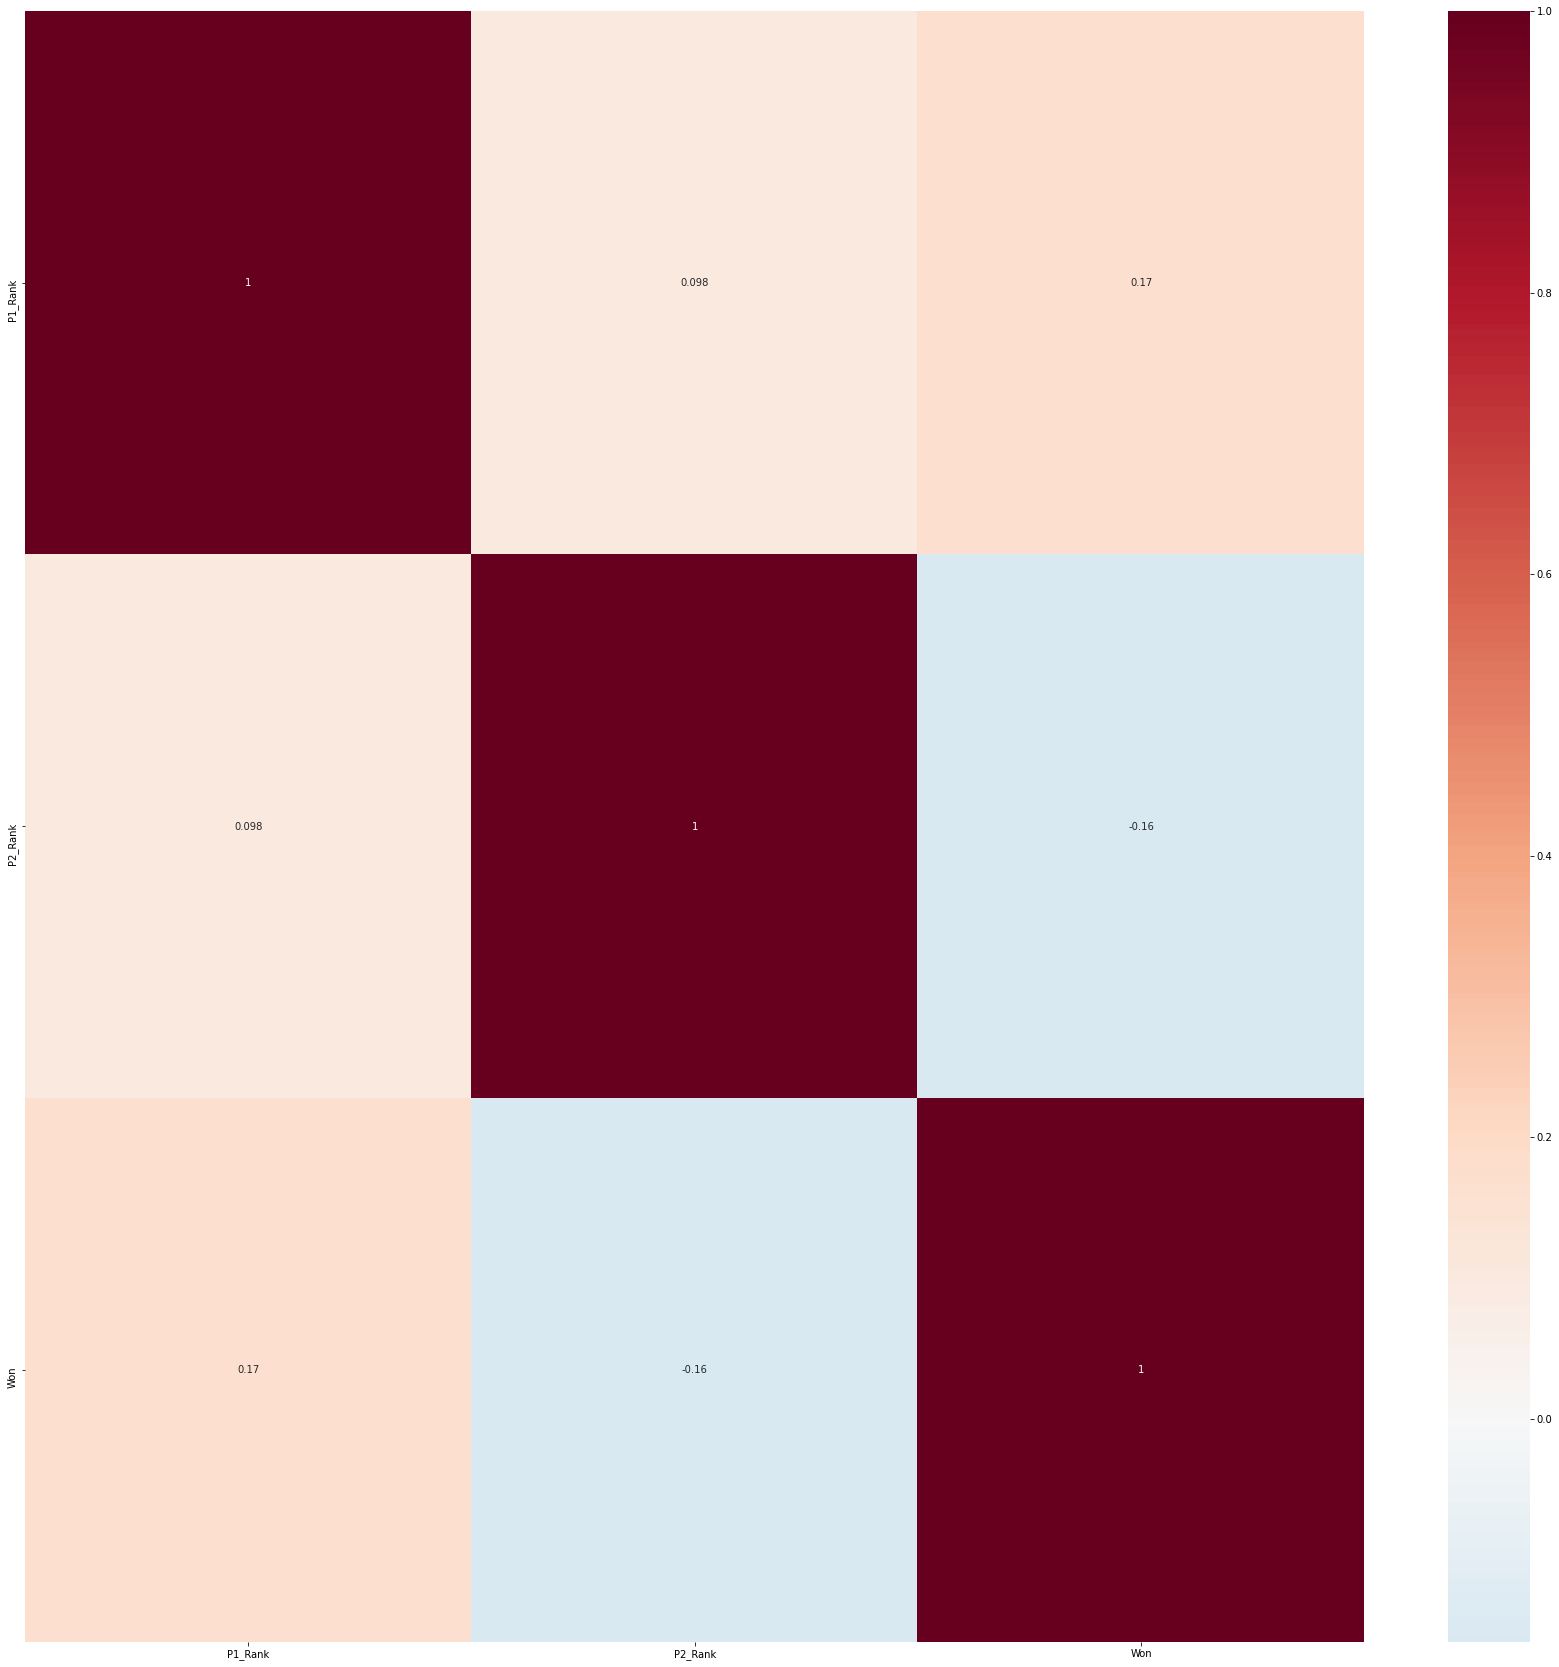

In [ ]:
# Heatmap 

plt.figure(figsize=(30,30))
correlation = data.corr()
sns.heatmap(correlation,  annot=True, cmap="RdBu_r", center =0);
plt.show()

#### Data Split and normalization

In [ ]:
# Split data and target 

DATA = data.drop('Won',axis=1)
TARGET = data['Won']

In [ ]:
# Split train/test

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=7)

In [ ]:
# Normalization

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=0)
scaler=qt.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## **Model Selection**

In [ ]:
from sklearn import linear_model

# Model training

clf=linear_model.LogisticRegression(random_state=10)
clf.fit(X_train_scaled,y_train)

# Model assessment

y_pred = clf.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',clf.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


Classe prédite    1    2
Classe réelle           
1               878  502
2               532  911

Score: 0.6337229897272405

               precision    recall  f1-score   support

           1       0.62      0.64      0.63      1380
           2       0.64      0.63      0.64      1443

    accuracy                           0.63      2823
   macro avg       0.63      0.63      0.63      2823
weighted avg       0.63      0.63      0.63      2823



In [ ]:
# Prediction of a new instance

Xnew = [[112,325],[57,161],[144,149],[208,154],[137,55],[190,166]]
Xnew = scaler.transform(Xnew)

# make a prediction

ypred = clf.predict(Xnew)

print("Prediction:",ypred)

ynew_prob = clf.predict_proba(Xnew)

print("Predicted=%s" % (ynew_prob))

Prediction: [1 1 1 2 2 2]
Predicted=[[0.58466158 0.41533842]
 [0.69210316 0.30789684]
 [0.50543361 0.49456639]
 [0.47759534 0.52240466]
 [0.32311976 0.67688024]
 [0.4909658  0.5090342 ]]


In [ ]:
stop

NameError: ignored

In [ ]:
# Weights

plt.figure(figsize=(7,7))

pd.Series(clf.coef_[0], X_train.columns).sort_values(ascending=False).plot(kind='barh');

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_scaled, y_train) 
y_pred = clf.predict(X_test) 
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Model training

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:
from lightgbm.sklearn import LGBMClassifier

clf = LGBMClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

# **TESTS / WORK IN PROGRESS** 

**LOGISTIC REGRESSION OPTIMIZATION**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
lr = LogisticRegression()               

pipe = Pipeline([ ('scaling', scaler),     
                 ('model', lr)])           

param_grid = { 
    'model__solver' : ['lbfgs', 'liblinear'], 
    'model__C': [10**(i) for i in range(-4,3)]    
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


**SVC OPTIMIZATION**

In [ ]:
#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

#scaler = QuantileTransformer()  # Normalization
#SVM = svm.SVC()             

#pipe = Pipeline([ ('scaling', scaler),    
                 #('model', SVM)])           

#param_grid = {
    #'model__kernel' : ['rbf', 'linear'], 
    #'model__C': [10**(i) for i in range(-4,3)]   
#}

#grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

#grid.fit(X_train,y_train)  

#print(grid.best_params_) # Best parameters
#print(grid.best_score_) # Best cross validation score

# Model assessment

#y_pred = grid.predict(X_test)

# Confusion Matrix 

#cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
#print(cm)

# Score

#print('\n''Score:',grid.score(X_test, y_test))

#Classification report

#print('\n',classification_report(y_test, y_pred))

**LINEAR DISCRIMINANT ANALYSIS OPTIMISATION**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

#scaler = StandardScaler()
scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
ld = LinearDiscriminantAnalysis()            

pipe = Pipeline([ ('scaling', scaler),   
                 ('model', ld)])           

param_grid = { 
    'model__solver' : ['svd', 'lsqr', 'eigen']   
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 4, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

**LGBM OPTIMZATION**

In [ ]:

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
lgbm = LGBMClassifier()           

pipe = Pipeline([ ('scaling', scaler),  
                 ('model', lgbm)])           

param_grid = { 
    'model__max_depth' : [1,3,5,7],   
    'model__learning_rate' : [0.001,0.01,0.1,1,10],
    'model__n_estimators' : [100,400],
    'model__num_leaves' : [2,5,10]
  }

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

#grid.fit(X_train,y_train)  

#print(grid.best_params_) # Best parameters
#print(grid.best_score_) # Best cross validation score

# Model assessment

#y_pred = grid.predict(X_test)

# Confusion Matrix 

#cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
#print(cm)

# Score

#print('\n''Score:',grid.score(X_test, y_test))

#Classification report

#print('\n',classification_report(y_test, y_pred))